# ***Modeling a Jacket Structure with a Wind Turbine Under Earthquake Forcing***

## **Introduction**

In this tutorial, we model a **jacket structure** supporting a wind turbine, subjected to earthquake forcing. Jacket structures are widely used in offshore wind engineering for their ability to withstand environmental loads such as waves, wind, and seismic activity. This analysis focuses on the **time-dependent dynamic behavior** of the structure using **Timoshenko beam theory**, which is particularly suited for capturing both bending and shear deformation.

### Objectives

This tutorial will guide you through:
1. Defining the physical problem and applying boundary conditions (BCs).
2. Setting up constant parameters such as material properties and damping factors.
3. Importing the pre-defined mesh and identifying labels for structural components.
4. Defining triangulations and boundary sets to model the geometry effectively.
5. Building finite element spaces (FESpaces) for the unknown quantities of interest.
6. Writing the weak form of the governing equations in a transient formulation.
7. Solving the problem numerically and postprocessing the results.

### Structure of the Tutorial

The tutorial follows these steps:
1. **Define the Physical Problem and BCs:** Establish the governing equations, BCs, and dynamic loading.
2. **Set Constant Parameters:** Specify material and geometric properties, such as $E$, $\rho$, $A$, and $I$.
3. **Import the Mesh:** Load a pre-defined mesh representing the jacket structure.
4. **Define Triangulations and Boundaries:** Organize the mesh for applying BCs and loads.
5. **Build FESpaces:** Define spaces for $v$ (displacement) and $\theta$ (rotation).
6. **Write the Weak Form:** Implement the transient weak form in Gridap.
7. **Solve and Postprocess:** Solve the transient problem numerically and visualize displacements and rotations.

We highly recommend the reader to visit https://oriolcg.github.io/GridapOffshore.jl/Theory/tutorial_Timoshenko/Timoshenko/ before starting with this tutorial.


In [139]:
using Gridap
using Plots
using GridapMakie
using CairoMakie 
using GLMakie
using Gridap.Geometry
using GridapGmsh
using WriteVTK
using Gmsh: Gmsh, gmsh

### Mesh Generation for the Jacket Structure

This cell generates a 1D mesh for the jacket structure using the Gmsh API. The specifics of mesh generation, such as setting characteristic lengths and exporting the mesh, are handled automatically and do not require the student’s detailed understanding at this stage.


In [ ]:
# Initialize the Gmsh API
gmsh.initialize()

# Open the .geo file
geo_file = "./msh_files/OFFSHORE_NASAL_JACKET.geo"
gmsh.open(geo_file)

# Set options to ensure lines are not subdivided
gmsh.option.set_number("Mesh.ElementOrder", 1)

gmsh.option.set_number("Mesh.CharacteristicLengthMax", 0.1)
gmsh.option.set_number("Mesh.CharacteristicLengthMin", 0.1)

# Generate the mesh
gmsh.model.mesh.generate(1)  # Generate a 1D mesh (the physical elements are 1D (!))

# Save as .msh file
msh_file = "./msh_files/OFFSHORE_NASAL_JACKET.msh"
gmsh.write(msh_file)

# Finalize Gmsh
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 50%] Meshing curve 12 (Line)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 60%] Meshing curve 16 (Line)
Info    : [ 60%] Meshing curve 17 (Line)
Info    : [ 70%] Meshing curve 18 (Line)
Info    : [ 70%] Meshing curve 19 (Line)
Info    : [ 80%] Meshing curve 20 (Line)
Info    : [ 80%] Meshing curve 21 (Line)
Info    : [ 80%] Meshing curve 22 (Line)
Info    : [ 90%] Meshing curve 23 (Line)
Info    : [ 90%] Meshing curve 24 (Line)
I

### **Physical Problem for the Jacket Structure Under Earthquake Forcing**

We model the jacket structure supporting a wind turbine using **Timoshenko beam theory**, which accounts for both bending and shear deformations. The structure is subjected to earthquake-induced displacements at its supports, with a point mass representing the nacelle at the top. Although the mesh we consider is in 2D space, the elements of the jacket are considered as **1D elements**. Therefore, our governing equations will be formulated in 1D space. We will later see that Gridap is inherently able to map the problem according to the layout of the elements found in the mesh. Therefore, the definition of the mesh sufficies to deal with the mapping. 

#### **Governing Equations**

The dynamic behavior of the beam is described by the following equations:

1. **Transverse Displacement Equation:**
   $$
   \rho A \frac{\partial^2 v}{\partial t^2} - \frac{\partial}{\partial x} \left( G A \left( \frac{\partial v}{\partial x} - \theta \right) \right) = f_v
   $$
   where:
   - $v(x, t)$: Transverse displacement
   - $\rho$: Material density
   - $A$: Cross-sectional area
   - $G$: Shear modulus
   - $\theta(x, t)$: Rotation of the cross-section
   - $f_v$: External transverse load per unit length

2. **Rotation Equation:**
   $$
   I \frac{\partial^2 \theta}{\partial t^2} - \frac{\partial}{\partial x} \left( E I \frac{\partial \theta}{\partial x} \right) + G A \left( \frac{\partial v}{\partial x} - \theta \right) = f_\theta
   $$
   where:
   - $I$: Second moment of area
   - $E$: Young's modulus
   - $f_\theta$: External moment per unit length

#### Boundary Conditions

1. **Displacement at Supports:**
   At the supports, the transverse displacement is prescribed to match the earthquake-induced displacement:
   $$
   v(x_{\text{support}}, t) = v_{\text{ext}}(t)
   $$

2. **Zero Rotation at Supports:**
   The rotation at the supports is constrained to zero:
   $$
   \theta(x_{\text{support}}, t) = 0
   $$

3. **Point Mass at Nacelle:**
   A point mass $m_{\text{nacelle}}$ is attached at the top of the wind turbine, introducing additional inertia. This modifies the boundary conditions at the free end:
   $$
   \left. \rho A \frac{\partial^2 v}{\partial t^2} \right|_{x=L} = m_{\text{nacelle}} \frac{\partial^2 v}{\partial t^2}
   $$

These equations and boundary conditions define the dynamic response of the jacket structure under earthquake loading, considering both bending and shear effects as per Timoshenko beam theory.


In [141]:
# Define known parameters/functions for the rod equation
E = 2e9 # Young's modulus (Pa)
ρ = 7850 # Density of steel (kg/m3)

# Nacelle
M_Nacelle = 5000 # kg

# Pile 
m_Pile(x) = 1000 # kg/m

# Jacket 
m_Jacket(x) = 100 # N/m 

# Define the known parameters/functions for the Timoschenko beam equation
ν = 0.2 # Poisson's ratio
EI_Pile = 1e9 # Nm2
EI_Jacket = 1e7 # Nm2

G = E/(2*(1+ν)) # Shear modulus (Pa)
GA_Jacket = G*(EA_Jacket/E) # Shear stiffness of jacket elements (N)
GA_Pile = G*(EA_Pile/E) # Shear stiffness of pile elements (N)

ρI_Jacket = ρ*(EI_Jacket/E)
ρI_Pile = ρ*(EI_Pile/E)

ρA_Jacket = ρ*(EA_Jacket/E)
ρA_Pile = ρ*(EA_Pile/E)

# Define load parameters
f0 = 2                          # [Hz]
A0 = 0.1                        # [m]
T0 = 20                         # [s]

# Define the support earthquake function
v_ext(t) = A0*sin(2*π*f0*t)   # [m]

# Load the mesh
model = GmshDiscreteModel("msh_files/OFFSHORE_NASAL_JACKET.msh")

Info    : Reading 'msh_files/OFFSHORE_NASAL_JACKET.msh'...
Info    : 48 entities
Info    : 4429 nodes
Info    : 4439 elements
Info    : Done reading 'msh_files/OFFSHORE_NASAL_JACKET.msh'


UnstructuredDiscreteModel()

In [143]:
# Get the labels of the entities in the model (this was already taken care of and pre-defined in the mesh file)
labels = get_face_labeling(model)
initial_tags = get_tag_entities(labels)[end]
tag_from_names = get_tag_from_name(labels)

Dict{String, Int64} with 5 entries:
  "Jacket Members" => 4
  "Pile Members"   => 5
  "Supports"       => 1
  "Bottom Pile"    => 3
  "Nacelle"        => 2

In [144]:
# Set up the figure and axis 
fig = Figure(resolution=(800, 600))
ax = Axis(fig[1, 1], title="Domain with Boundary Tags", xlabel="x", ylabel="y")

for intgr in length(tag_from_names)
    CairoMakie.wireframe!(ax, Triangulation(model))
end

CairoMakie.scatter!(ax, Boundary(Triangulation(model), tags="Supports"))
CairoMakie.scatter!(ax, Boundary(Triangulation(model), tags="Nacelle"))
CairoMakie.scatter!(ax, Boundary(Triangulation(model), tags="Jacket Members"))
CairoMakie.scatter!(ax, Boundary(Triangulation(model), tags="Pile Members"))

fig

### **Defining Domain and Boundary Triangulations**

In this cell, we define the computational domain and its subdivisions to facilitate the application of boundary conditions and material properties:

- `Ω`: Represents the entire computational domain as a triangulation of the model.
- `Ω_pile`: Defines the subdomain corresponding to the pile members, identified by the tag `"Pile Members"`.
- `Ω_jacket`: Defines the subdomain corresponding to the jacket members, identified by the tag `"Jacket Members"`.
- `Γ_S`: Represents the boundary of the jacket subdomain where supports are located, identified by the tag `"Supports"`.
- `Γ_N`: Represents the boundary of the pile subdomain at the nacelle location, identified by the tag `"Nacelle"`.


In [129]:
Ω = Triangulation(model)
Ω_pile = Triangulation(model, tags="Pile Members")
Ω_jacket = Triangulation(model, tags="Jacket Members")
Γ_S = Boundary(Ω_jacket,tags="Supports")
Γ_N = Boundary(Ω_pile,tags="Nacelle")

CompositeTriangulation()

### **Defining Finite Element Spaces for the Transient Timoshenko Beam Problem**

In this step, we define the finite element spaces necessary for solving the transient Timoshenko beam equations:

1. **Reference Finite Elements:**  
   We use Lagrangian reference finite elements of order 1 to represent the displacement ($v$) and rotation ($\theta$) fields.

2. **Test Function Spaces:**  
   The test spaces for displacement and rotation are defined over the domain $\Omega$, with Dirichlet boundary conditions applied to enforce constraints at the supports.

3. **Trial Function Spaces:**  
   For displacement, we define a transient trial space to incorporate the time-dependent boundary condition $v_{\text{ext}}(t)$ representing earthquake excitation. The rotation space is similarly defined but does not include external forcing.

4. **Multi-Field Spaces:**  
   The coupled displacement and rotation fields are combined into multi-field finite element spaces, enabling the simultaneous solution of the governing equations. This is due to the coupled-nature of the Timoschenko beam theory.

These spaces form the foundation for discretizing the Timoshenko beam equations in the transient analysis.

In [146]:
# Transient problem
order = 1

reffe_v = ReferenceFE(lagrangian, Float64, order) 
reffe_θ = ReferenceFE(lagrangian, Float64,order)

v_Y = TestFESpace(Ω, reffe_v; dirichlet_tags="Supports") # The TestFESpace for the displacement in Timoschenko equation
θ_Y = TestFESpace(Ω, reffe_θ; dirichlet_tags="Supports") # The TestFESpace for the rotation in Timoschenko equation 

v_X = TransientTrialFESpace(v_Y, v_ext) # The TransientTrialFESpace for the displacement in Timoschenko equation
θ_X = TransientTrialFESpace(θ_Y) # The TransientTrialFESpace for the rotation in Timoschenko equation 

X = TransientMultiFieldFESpace([v_X,θ_X])
Y = MultiFieldFESpace([v_Y,θ_Y])

MultiFieldFESpace()

### **Defining Numerical Integration Measures**

This cell defines the integration measures required for performing numerical integration over the different parts of the domain and boundaries:

- **Quadrature Degree:**  
  A first-order Gaussian quadrature rule ($\text{degree} = 1$) is used to prevent shear locking, which can occur in Timoshenko beam formulations when higher-degree quadrature is unnecessarily applied to shear terms.

- **Domain Integration Measures:**
  - `dΩ_Pile`: Integration measure for the pile members domain ($\Omega_{\text{Pile}}$).
  - `dΩ_Jacket`: Integration measure for the jacket members domain ($\Omega_{\text{Jacket}}$).

- **Boundary Integration Measures:**
  - `dΓ_N`: Integration measure along the nacelle boundary ($\Gamma_{\text{Nacelle}}$).
  - `dΓ_S`: Integration measure along the supports boundary ($\Gamma_{\text{Supports}}$).

These measures ensure accurate numerical evaluation of integrals over both the domain and boundaries, facilitating the application of the weak form for the Timoshenko beam equations.


In [147]:
degree = 1 # Degree of the quadrature rule == 1 to prevent shear locking

dΩ_Pile = Measure(Ω_pile, degree) # Numerical integration within the domain Ω using first-order Gaussian quadrature rule
dΩ_Jacket = Measure(Ω_jacket, degree) # Numerical integration within the domain Ω_jacket using first-order Gaussian quadrature rule

dΓ_N = Measure(Γ_N,degree) # Numerical integration along the Nacelle boundary Γ_N using first-order Gaussian quadrature rule
dΓ_S = Measure(Γ_S,degree) # Numerical integration along the supports Γ_S using first-order Gaussian quadrature rule

GenericMeasure()

### **Deriving the Weak Form for the Timoshenko Beam**

The weak form of the Timoshenko beam equations is derived by multiplying the governing equations by test functions and integrating over the domain. The process incorporates contributions from the mass, stiffness, and external forces, resulting in the bilinear and linear forms necessary for finite element discretization.

#### Weak Form Components

1. **Mass Terms ($m_{\text{timo}}$):**
   The mass terms account for inertia effects and are derived from the dynamic equilibrium equations:
   $$
   m_{\text{timo}}(t, (\ddot{v}, \ddot{\theta}), (w, \psi)) =
   \int_{\Omega_{\text{Jacket}}} \rho A \, \ddot{v} \cdot w \, d\Omega +
   \int_{\Omega_{\text{Jacket}}} \rho I \, \ddot{\theta} \cdot \psi \, d\Omega +
   \int_{\Omega_{\text{Pile}}} \rho A \, \ddot{v} \cdot w \, d\Omega +
   \int_{\Omega_{\text{Pile}}} \rho I \, \ddot{\theta} \cdot \psi \, d\Omega +
   \int_{\Gamma_{\text{Nacelle}}} M_{\text{Nacelle}} \ddot{v} \cdot w \, d\Gamma
   $$

2. **Damping Terms ($c_{\text{timo}}$):**
   The damping terms, representing velocity-dependent effects, are included as:
   $$
   c_{\text{timo}}(t, (\dot{v}, \dot{\theta}), (w, \psi)) = 0
   $$

3. **Stiffness Terms ($a_{\text{timo}}$):**
   The stiffness terms capture the elastic behavior of the beam, incorporating bending and shear deformation:
   $$
   a_{\text{timo}}(t, (v, \theta), (w, \psi)) =
   \int_{\Omega_{\text{Jacket}}} EI \, (\nabla \theta \cdot \nabla \psi) + GA \, ((\nabla v - \theta) \cdot (\nabla w - \psi)) \, d\Omega +
   \int_{\Omega_{\text{Pile}}} EI \, (\nabla \theta \cdot \nabla \psi) + GA \, ((\nabla v - \theta) \cdot (\nabla w - \psi)) \, d\Omega
   $$

4. **External Force Terms ($l_{\text{timo}}$):**
   The external forces are represented as:
   $$
   l_{\text{timo}}(t, (w, \psi)) = \int_{\Gamma_{\text{Nacelle}}} f_{\text{ext}} \cdot w \, d\Gamma
   $$
   Here, no external force is applied in this setup, so $f_{\text{ext}} = 0$.

#### Transient Operator Assembly

The components are combined into a transient finite element operator:
- **Mass Term ($m_{\text{timo}}$):** Accounts for inertia effects.
- **Damping Term ($c_{\text{timo}}$):** Includes any velocity-dependent effects (zero in this case).
- **Stiffness Term ($a_{\text{timo}}$):** Represents elastic and shear stiffness contributions.
- **External Forces ($l_{\text{timo}}$):** Includes transient forces applied to the beam.

This operator is defined as:
```julia
op_timo = TransientAffineFEOperator(m_timo, c_timo, a_timo, l_timo, X, Y)

In [148]:
# Bilinear form including time-dependent mass terms
m_timo(t, (dttv, dttθ), (w,ψ)) = ∫(ρI_Jacket * dttθ ⋅ ψ)dΩ_Jacket + ∫(ρI_Pile * dttθ ⋅ ψ)dΩ_Pile + 
                                ∫(ρA_Jacket * dttv ⋅ w)dΩ_Jacket  + ∫(ρA_Pile * dttv ⋅ w)dΩ_Pile +
                                ∫(M_Nacelle*dttv⋅w)dΓ_N

# Bilinear form including time-dependent damping terms (no damping in this model)                             
c_timo(t, (dtv, dtθ),  (w,ψ)) = ∫(0*dtv⋅w)dΩ_Jacket + ∫(0*dtv⋅w)dΩ_Pile

# Bilinear form including time-dependent stiffness terms
a_timo(t, (v,θ), (w,ψ)) = ∫(EI_Jacket*(∇(θ)⊙∇(ψ)) + GA_Jacket* ((∇(v)-θ)⋅(∇(w)-ψ)) )dΩ_Jacket +
                      ∫(EI_Pile*(∇(θ)⊙∇(ψ)) + GA_Pile*((∇(v)-θ)⋅(∇(w)-ψ)) )dΩ_Pile

# Linear form for transient external forces
l_timo(t, (w,ψ)) = ∫(0 * w)dΓ_N

op_timo = TransientAffineFEOperator(m_timo, c_timo, a_timo, l_timo,X,Y)

TransientFEOperatorFromWeakForm()

### **Solving the Transient Timoshenko Beam Problem**

We solve the transient problem using the **Newmark-beta method**, a time integration scheme for dynamic structural analysis. 

- **Time Interval:** The simulation runs from $t_0 = 0.0$ to $t_F = 10.0$, with a time step of $\Delta t = 0.05$.
- **Initial Conditions:** The structure starts at rest, with zero initial displacement, velocity, and acceleration.

Using the assembled transient operator `op_timo` and the initial conditions, the solver computes the time-dependent response of the jacket structure. The solution provides the displacement and rotation fields over the specified time interval.

In [150]:
# Solution
γₜ = 0.5
βₜ = 0.25
ls = LUSolver()
Δt = 0.05
ode_solver = Newmark(ls,Δt,γₜ,βₜ)

# Time interval
t0, tF = 0.0, 10.0

# Initial solution
x0_timo = interpolate_everywhere([0.0,0.0],X(0.0))
v0_timo = interpolate_everywhere([0.0,0.0],X(0.0))
a0_timo = interpolate_everywhere([0.0,0.0],X(0.0))

xt_timo = solve(ode_solver,op_timo,(x0_timo,v0_timo,a0_timo),t0,tF)

Gridap.ODEs.TransientFETools.TransientFESolution(GenericODESolution(), TransientMultiFieldTrialFESpace{Gridap.MultiField.ConsecutiveMultiFieldStyle, Gridap.FESpaces.UnConstrained, Vector{Float64}}(Vector{Float64}, Any[TransientTrialFESpace{Gridap.FESpaces.UnconstrainedFESpace{Vector{Float64}, Gridap.FESpaces.NodeToDofGlue{Int32}}, TrialFESpace{Gridap.FESpaces.UnconstrainedFESpace{Vector{Float64}, Gridap.FESpaces.NodeToDofGlue{Int32}}}}(UnconstrainedFESpace(), v_ext, TrialFESpace()), TrialFESpace()], Gridap.MultiField.ConsecutiveMultiFieldStyle(), Gridap.FESpaces.UnConstrained()))

### **Post-processing**

In [151]:
output_dir = "results/"
vtk_output = true

if vtk_output == true
    pvd_v = paraview_collection(output_dir * "_v_solution", append=false)
    pvd_theta = paraview_collection(output_dir * "_theta_solution", append=false)
  end

# Time stepping for visualization
times = t0:Δt:tF

Nacelle_v = []
Nacelle_theta = []

for ((v,θ), t) in xt_timo
    # Write to VTK
    push!(Nacelle_v, evaluate(v, Gridap.Point(0.0, 100.0)))
    push!(Nacelle_theta, evaluate(θ, Gridap.Point(0.0, 100.0)))

    push!(Nacelle_v_pile, evaluate(v, Gridap.Point(0.0, 0.1)))
    push!(Nacelle_v_jacket, evaluate(v, Gridap.Point(0.01, 0.0)))
    if vtk_output == true
        pvd_v[t] = createvtk(Ω,output_dir * "_v_solution" * "_$t.vtu",cellfields = ["v" => v],nsubcells=10)
        pvd_theta[t] = createvtk(Ω,output_dir * "_theta_solution" * "_$t.vtu",cellfields = ["theta" => θ],nsubcells=10)
      end
end

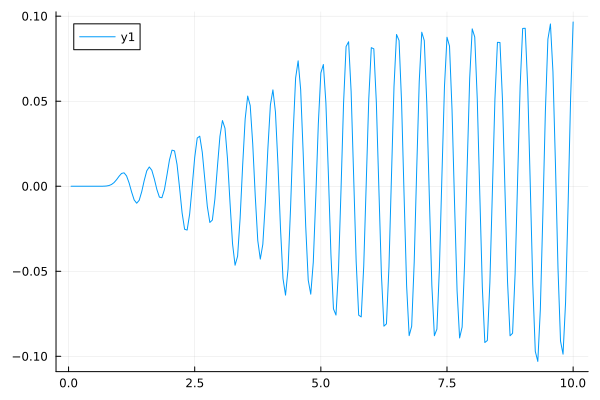

In [154]:
Plots.plot(times[2:end], Nacelle_v)